# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{pmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

#### Implement ```band_lu```:

In [379]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

In [380]:
# INPUT : diag_broadcast - list of diagonals value to broadcast, length equal to 3 or 5;
#         n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1;
#              do not store main diagonal, where all ones;
#              add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n):
    assert len(diag_broadcast) in {3, 5}, 'Wrong input!'
    assert n >= len(diag_broadcast), 'Too small size!'
    
    diag_broadcast = np.array(diag_broadcast, dtype=float)
    len_old = len(diag_broadcast)
    if len(diag_broadcast) == 3:
        try:
            diag_broadcast = np.concatenate(([0], diag_broadcast, [0]))
        except:
            raise ValueError('A list of diagonal values is expected as diag_broadcast!')
    
    a, b, c, d, e = diag_broadcast
    
    alpha = np.zeros(n - 2, dtype=float)
    beta = np.zeros(n - 1, dtype=float)
    gamma = np.zeros(n, dtype=float)
    delta = np.zeros(n - 1, dtype=float)
    
    gamma[0] = 1.
    delta[0] = d
    beta[0] = b
    gamma[1] = c - b * d
    
    for i in range(2, n):
        if abs(gamma[i - 2]) < 1e-12:
            raise ZeroDivisionError('Pivot is too small, probably singular matrix!')
        alpha[i - 2] = a / gamma[i - 2]
        if abs(gamma[i - 1]) < 1e-12:
            raise ZeroDivisionError('Pivot is too small, probably singular matrix!')
        beta[i - 1] = (b - alpha[i - 2] * delta[i - 2]) / gamma[i - 1]
        delta[i - 1] = d - beta[i - 2] * e
        gamma[i] = c - alpha[i - 2] * e - beta[i - 1] * delta[i - 1]
    
    L = np.zeros((2, n - 1))
    U = np.zeros((n, 3))

    L[0, :] = beta
    L[1, :-1] = alpha

    U[:, 0] = gamma
    U[:-1, 1] = delta
    U[:-2, 2] = e
    
    if len_old == 3:
        return L[:-1, :], U[:, :-1]
    return L, U    

Example: try changing ```n``` and ```diag_broadcast```. Code for example works for both ```len(diag_broadcast) = 3``` and ```len(diag_broadcast) = 5```

In [381]:
def get_A(diag_broadcast, n):
    nd = len(diag_broadcast)
    m = nd // 2
    ex = np.ones((1, n))
    diag_broadcast = np.reshape(diag_broadcast, (nd, 1)) * ex
    diag_broadcast[m, 0] = 1.
    A = diags(diag_broadcast, range(-m, m + 1), (n, n))
    return A

In [235]:
n = 10
diag_broadcast = [1, 2, 1]
m = len(diag_broadcast) // 2

A = get_A(diag_broadcast, n)
print('A:', A.toarray(), sep='\n')

A:
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]]


In [236]:
def my_LU(diag_broadcast, n):
    L, U = band_lu(diag_broadcast, n)
    m = len(diag_broadcast) // 2
    data = [L[i, :] for i in range(m)]
    my_L = diags([[1] * n, *data], range(0, -m - 1, -1))
    my_U = diags([U[:, i] for i in range(m + 1)], range(0, m + 1), (n, n))
    return my_L, my_U

In [237]:
L, U = band_lu(diag_broadcast, n)
print('L:', L, sep='\n')
print('U:', U, sep='\n')

my_L, my_U = my_LU(diag_broadcast, n)
print('my L:', my_L.toarray(), sep='\n')
print('my U:', my_U.toarray(), sep='\n')

print('my A = L U:', (my_L @ my_U).toarray(), sep='\n')

L:
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]]
U:
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]]
my L:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
my U:
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
my A = L U:
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 1

#### Extensive testing

In [281]:
from scipy.sparse.linalg import norm as scspnorm

In [282]:
diag_broadcast = [1, 2, 1]
nvals = range(5, 130)
errors = []
for n in nvals:
    A = get_A(diag_broadcast, n)
    my_L, my_U = my_LU(diag_broadcast, n)
    err = scspnorm(my_L @ my_U - A) / scspnorm(A)
    errors.append(err)

In [270]:
import matplotlib.pyplot as plt

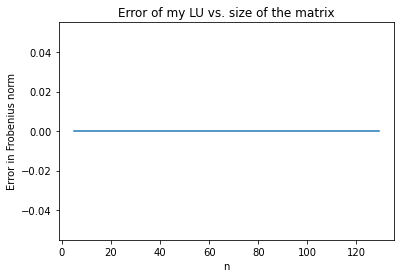

In [271]:
plt.plot(nvals, errors)
plt.title('Error of my LU vs. size of the matrix')
plt.xlabel('n')
plt.ylabel('Error in Frobenius norm');

Error is absolute zero so it is impossible to set log scale.

In [325]:
(np.array(errors) == 0).all()

True

#### Compare with Scipy LU

In [277]:
from scipy.linalg import lu as sclu

In [315]:
my_times = []
sc_times = []
diag_broadcast = [1, 2, 1]
nvals = np.arange(5, 1000, 20)
for n in nvals:
    my_time = %timeit -o -q -n 5 my_LU(diag_broadcast, n)
    my_times.append(np.mean(my_time.timings))

    A = get_A(diag_broadcast, n).toarray()
    sc_time = %timeit -o -q -n 5 lu(A)
    sc_times.append(np.mean(sc_time.timings))

In [316]:
import matplotlib.pyplot as plt

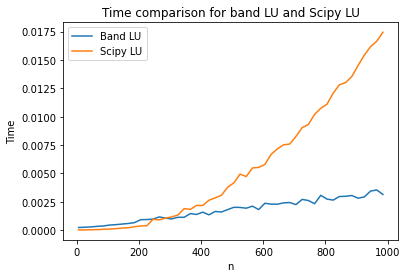

In [324]:
plt.plot(nvals, my_times, label='Band LU')
plt.plot(nvals, sc_times, label='Scipy LU')

plt.title('Time comparison for band LU and Scipy LU')
plt.xlabel('n')
plt.ylabel('Time')
plt.legend();

One can see that band LU takes linear time when scipy takes $O(n^3)$. For $n >= 300$ approximately our implementation is faster than Scipy.

#### Implement Cholesky factorization

In [338]:
def cholesky(A):
    A = np.array(A, dtype=float)
    assert (A == A.T).all(), 'A has to be symmetrical!'
    
    L = np.zeros(A.shape, dtype=float)
    L[0, 0] = np.sqrt(A[0, 0])
    L[1:, 0] = A[1:, 0] / L[0, 0]
    n = A.shape[0]
    for j in range(1, n):
        L[j, j] = np.sqrt(A[j, j] - (L[j, :j]**2).sum())
        L[j + 1:, j] = 1 / L[j, j] * (A[j + 1:, j] - (L[j, :j] * L[j + 1:, :j]).sum(axis=1))
    
    return L

Complexity of Cholesky factorization $O(n^3/3)$ and LU complexity is $O(2 n^3/3)$. Cholesky complexity is twice smaller than LU complexity because we have twice less parameters two calculate given that the matrix $A$ is symmetric.

#### Compare with analytical solution for Pascal matrices

In [360]:
def lower_pascal(n, dtype=int):
    L = np.eye(n, dtype=dtype)
    L[1:, 0] = 1
    for i in range(2, n):
        L[i, 1:i] = L[i - 1, :i - 1] + L[i - 1, 1:i]
    
    return L

def pascal(n, dtype=int):
    L = lower_pascal(n)
    return L @ L.T

In [369]:
S = pascal(5)
my_L = cholesky(S)
np.linalg.norm(my_L @ my_L.T - S, ord=2) / np.linalg.norm(S, ord=2)

0.0

In [370]:
S = pascal(10)
my_L = cholesky(S)
np.linalg.norm(my_L @ my_L.T - S, ord=2) / np.linalg.norm(S, ord=2)

0.0

In [371]:
S = pascal(50)
my_L = cholesky(S)
np.linalg.norm(my_L @ my_L.T - S, ord=2) / np.linalg.norm(S, ord=2)

C:\Users\kuzne\AppData\Local\Temp/ipykernel_15980/1532558030.py:10: RuntimeWarning: invalid value encountered in sqrt
  L[j, j] = np.sqrt(A[j, j] - (L[j, :j]**2).sum())


ValueError: On entry to DLASCL parameter number 5 had an illegal value

Our implementation works correctly for small $n$ but for $n = 50$ we have overflow. This happens because the analytical expression for Pascal matrices coefficients is given by binomial coefficients:

$$S_{ij} = \frac{(i + j)!}{i! j!}$$

In [340]:
A = np.array([[1, 1, 1, 1], [1, 2, 3, 4], [1, 3, 6, 10], [1, 4, 10, 20]])
cholesky(A)

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 2., 1., 0.],
       [1., 3., 3., 1.]])

Even though we do not calculate factorials explicitly and instead use sum of previous entries, in case of $n = 50$ the values become too large and integer overflow occurs.

### 2. Stability of LU (8 pts)

* (4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?



$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}.$ 

$B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}.$ 

* (4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?

$A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}.$ 

#### LU fails
Let us try applying usual LU algorithm w/o pivoting (https://stackoverflow.com/questions/48370944/lu-decomp-without-pivoting-in-python)

In [392]:
# Your solution is here
def LU(A):
    n = len(A)
    B = A.copy()
    for k in range(0, n - 1):
        for i in range(k + 1, n):
            if B[i, k] != 0.0:
                lam = B[i, k] / B[k, k]
                B[i, k + 1 : n] = B[i, k + 1 : n] - lam * B[k, k + 1 : n]
                B[i, k] = lam
    return B

In [393]:
A = np.array([[0, 1], [2, 3]])
LU(A)

C:\Users\kuzne\AppData\Local\Temp/ipykernel_15980/2546043575.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  lam = B[i, k] / B[k, k]


OverflowError: cannot convert float infinity to integer

In [394]:
B = np.array([[1, 1, 0], [1, 1, 2], [1, 2, 1]])
LU(B)

C:\Users\kuzne\AppData\Local\Temp/ipykernel_15980/2546043575.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  lam = B[i, k] / B[k, k]


OverflowError: cannot convert float infinity to integer

LU fails for both of this matrices.

From lectures and Internet (https://en.wikipedia.org/wiki/LU_decomposition#Existence_and_uniqueness) we know: if $A$ is invertible, then it admits an LU (or LDU) factorization if and only if all its leading principal minors are nonzero. If $A$ is a singular matrix of rank $k$, then it admits an LU factorization if the first $k$ leading principal minors are nonzero, although the converse is not true.

In case of $A$, the very first leading minor is zero so LU does not exist here. In case of $B$, the second leading minor is there because it consists only of ones. So LU is impossible here too. In both cases, these facts lead to division by zero which can be clearly seen from the LU algorithm above.

#### Zeros in pivot positions

In order for $A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}$ to have zero in second pivot position, the second leading principal minor $\textrm{det} \begin{pmatrix} 1 & c \\ 2 & 4 \end{pmatrix}$ has to be zero. We can achieve this by making the second row in this minor a multiple of first. For that, we should take $c = 2$.

In order to have zero in the third pivot position, the third minor $\textrm{det} \begin{pmatrix} 1 & c & 0 \\ 2 & 4 & 1 \\ 3 & 5 & 1 \end{pmatrix}$ has to be zero. To achieve this, we can make the third row a sum of the first and the second and take $c = 1$.

To address the possible zeros in pivot position, we can use partial pivoting (row permutations only): $P A = L U$ and full pivoting (both row and column permutations): $P A Q = L U$

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

#### Implement PLU

In [442]:
# Your solution is here
def plu(A):
    n = A.shape[0]
    P = np.eye(n)
    L = np.eye(n)
    U = A.copy()
    P_bar = np.eye(n)
    L_bar = np.zeros((n, n))
    
    for k in range(n - 1):
        i = np.argmax(abs(U[k:, k])) + k 
        if i != k:
            P = np.eye(n)
            P[[i, k], k:n] = P[[k, i], k:n]
            U[[i, k], k:n] = U[[k, i], k:n] 
            P_bar = P @ P_bar
            L_bar = P @ L_bar
        L = np.eye(n)
        L_bar[k + 1:, k] = (U[k + 1:, k] / U[k, k])
        L[k + 1:, k]  = -1 * L_bar[k + 1:, k]
        U = L @ U
        
    np.fill_diagonal(L_bar, 1)
    return P_bar.T, L_bar, U

#### Compare with built-in function on band matrices

In [424]:
from scipy.linalg import lu as sclu

In [433]:
nvals = range(5, 50, 5)
my_times = []
my_errors = []
sc_times = []
sc_errors = []
for n in nvals:
    A = get_A([1, 4, 3], n).toarray()
    
    my_time = %timeit -o -q -n 5 plu(A)
    my_times.append(np.mean(my_time.timings))
    
    sc_time = %timeit -o -q -n 5 sclu(A)
    sc_times.append(np.mean(sc_time.timings))
    
    my_P, my_L, my_U = plu(A)
    my_error = np.linalg.norm(np.linalg.inv(my_P) @ my_L @ my_U - A) / np.linalg.norm(A)
    my_errors.append(my_error)
    
    sc_P, sc_L, sc_U = sclu(A)
    sc_error = np.linalg.norm(sc_P @ sc_L @ sc_U - A) / np.linalg.norm(A)
    sc_errors.append(sc_error)

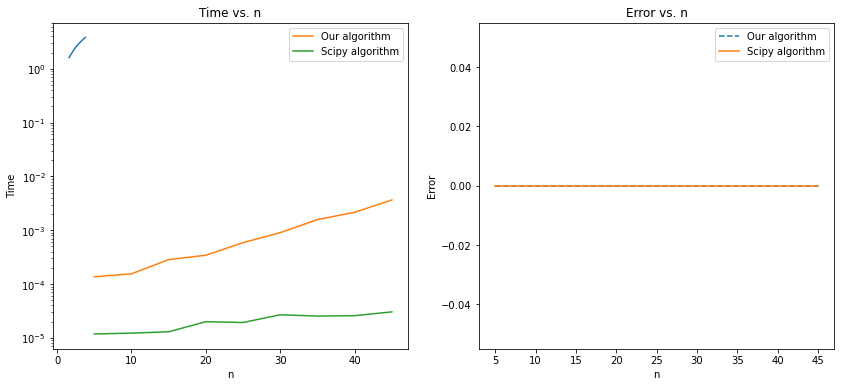

In [448]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.semilogy(nvals, my_times, label='Our algorithm')
plt.semilogy(nvals, sc_times, label='Scipy algorithm')
plt.title('Time vs. n')
plt.xlabel('n')
plt.ylabel('Time')
plt.legend()

plt.subplot(122)
plt.plot(nvals, my_errors, '--', label='Our algorithm')
plt.plot(nvals, sc_errors, label='Scipy algorithm')
plt.title('Error vs. n')
plt.xlabel('n')
plt.ylabel('Error')
plt.legend();

#### Pathological example

In [444]:
A = np.array([[0, 0, 1, 1], [0, 1, 2, 1], [1, 2, 1, 0], [1, 2, 0, 0]])
P, L, U = plu(A)
P, L, U

(array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 1.,  0., -1.,  1.]]),
 array([[1., 2., 1., 0.],
        [0., 1., 2., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]]))

In [445]:
np.linalg.inv(P) @ L @ U

array([[0., 0., 1., 1.],
       [0., 1., 2., 1.],
       [1., 2., 1., 0.],
       [1., 2., 0., 0.]])

#### Discussion of the results
Scipy algorithm is more optimized than ours because it works with highly-optimized low-level vectorized routines and our code has the same complexity $O(n^3)$. The only chance for python code that uses for loops to win a scipy or numpy algorithm is to have less complexity like with the band matrices case. In this case, the algorithms have the same complexity, so Scipy will always be faster. The error within machine precision limits for both algorithms.

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

#### Find $S$

Let $A = L U = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} = \begin{bmatrix} L_{11}U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$

$$U_{12} = L^{-1}_{11} A_{12}$$

$$L_{21} = A_{21} U^{-1}_{11} $$

$$L_{22} U_{22} = A_{22} - L_{21} U_{12} = A_{22} - A_{21} U^{-1}_{11} L^{-1}_{11} A_{12} = A_{22} - A_{21} A^{-1}_{11} A_{12}$$

$$A_{11}u_1 + A_{12}u_2 = f_1 \implies u_1 = A_{11}^{-1}(f_1 - A_{12}u_2)$$

$$A_{21}u_1 + A_{22}u_2 = f_2 \implies A_{22}u_2 = f_2 - A_{21}u_1 = f_2 - A_{21}(A_{11}^{-1}(f_1 - A_{12}u_2)) = f_2 - A_{21}A_{11}^{-1}f_1 + A_{21}A_{11}^{-1}A_{12}u_2$$

$$(A_{22}−A_{21}A^{−1}_{11}A_{12})u_2 = f_2−A_{21}A^{−1}_{11}f_1$$

$$L_{22}U_{22} = S$$

$$S = A_{22}−A_{21}A^{−1}_{11}A_{12}$$

$$\hat f_2 = f_2−A_{21}A^{−1}_{11}f_1$$

#### Property of Schur complement

$$\begin{bmatrix} X & A \\ -B & I \end{bmatrix} = \begin{bmatrix}
X & 0 \\
-B & I
\end{bmatrix} \begin{bmatrix}
I & X^{-1} A \\
0 & I+B X^{-1} A
\end{bmatrix} = $$

$$ = \begin{bmatrix}
X+A B & A \\
0 & I
\end{bmatrix} \begin{bmatrix}
I & 0 \\
-B & I
\end{bmatrix}$$

$$\textrm{det} \begin{bmatrix}
X & A \\
-B& I
\end{bmatrix} = $$

$$\textrm{det}(X + A B) = \det(X) \det(I+B X^{-1}A)$$

Using results of the previous task, $X = I_m$, $A = -F$, $B = G$

$$\det(I_m -FG) = \det(I_m)\det(I_n + GI_m(-F)) = \det(I_n - GF)$$

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)

* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

#### Subtask 1. Linearly independent eigenvectors

Let $S_n = [v_1,v_2,…,v_n]$ be eigenvectors, $[λ_1,λ_2,…,λ_n]$ - distinct eigenvalues.

Prove by induction.

Let $S_k=[v_1,v_2,…,v_k]$.

**Base of induction**

Eigenvectors are non-zero, so $S_1$ is linearly independent.

**Induction step:**

Assume $S_k$ is lin. independent.

Suppose there exist some $a_i$ so that $\sum_{i = 1}^{k + 1} a_i v_i=\theta$. If not, than we proved linear independence.

$\Theta= A\Theta = A \left( \sum_{i=1}^{k+1}a_iv_i \right)=\sum_{i=1}^{k+1}a_iA(v_i)=\sum_{i=1}^{k+1}a_iλ_iv_i=a_{k+1}λ_{k+1}v_{k+1}+\sum_{i=1}^{k}a_iλ_iv_i$

$\Theta=λ_{k+1}\Theta=λ_{k+1}\left( \sum_{i=1}^{k+1}a_iv_i \right)=\sum_{i=1}^{k+1}a_iλ_{k+1}v_i=a_{k+1}λ_{k+1}v_{k+1}+\sum_{i=1}^{k}a_iλ_{k+1}v_i$

Subtracting the above 2 equations:

$\Theta=\sum_{i=1}^k a_i(λ_i−λ_{k+1})v_i$

Since $S_k$ is linearly independent, for any $i≤k,a_i(λ_i−λ_{k+1})=0$. Since all $λ_i$ are distinct, all $a_i=0$ for $i \le k$.

$\Theta=\sum_{i=1}^{k+1}a_iv_i = a_{k+1}v_{k+1} + \sum_{i=1}^{k}a_iv_i = a_{k+1}v_{k+1} =\Theta$

Since $v_{k+1}≠\Theta$, $a_{k+1}=0$.

Since for any $i \le k + 1 \ a_i=0,\text{ then } S_{k+1}$ is linearly independent.

By the principle of mathematical induction, $S_n$ is linearly independent.

#### Subtask 2. Prove that $A$ has an eigenvalue 1 and...

Consider ```v = ones((n, 1))```. Then multiplying $A$ by $v$ means taking the vector of row sums which are all 1 and $A v = \begin{bmatrix} 1 \\ 1 \\ ... \\ 1 \\ \end{bmatrix} = $ ```ones((n, 1))``` $= 1 \cdot v$.

For any eigenpair $(\lambda, v)$ of $A$:

Let $|v|_{max}=\max_i|v_i|$

Since $Av=λv$, $\sum_j a_{ij}v_j = λv_i $

$|λ||v_i|=|\sum_j a_{ij}v_j| \leq \sum_j a_{ij}|v_j| \leq \sum_j a_{ij}|v|_{max} =|v|_{max} \sum_j a_{ij}=|v|_{max}$ for every $v_i \Rightarrow |λ||v|_{max}\leq |v|_{max}, |λ| \leq 1$

#### Subtask 3.

$$A v = \lambda v$$

$$v^* A v = v^* \lambda v = \lambda \|v\|^2_2$$

$$A v = \lambda v$$

Using that eigenvalues are real:

$$v^* A^* = (A v)^* = (\lambda v)^* = \lambda v^*$$

$$v^* A^* v = \lambda v^* v = \lambda \|v\|^2_2 = v^* A v$$

$$A^* = A$$ $A$ - unitary

If $|\lambda| = 1$:

$$Av=λv$$

$$v^* A^* = (A v)^* = (\lambda v)^* = \lambda^* v^*$$

$$v^* A^* \cdot A v = \lambda^* v^* \cdot \lambda v = v^* v$$

$$v^* A^* A = v^*$$

$$A^* A = I$$
$A$ is the normal matrix, so $A A^* = A^* A = I$, so $A^* = A^{-1}$ - $A$ is unitary.

To prove the input from the output, one can redo the calculations in the backward order.

#### Subtask 4.

$$\det (J(\varepsilon) - \lambda_i I) = \begin{vmatrix} \lambda - \lambda_i & 1 & & ... & 0 \\ 0 & \lambda - \lambda_i & 1 & & ... & 0 \\ \vdots & \vdots & & \vdots \\ \varepsilon & & & 0 & \lambda - \lambda_i \\ \end{vmatrix} = (\lambda - \lambda_i)^n + \varepsilon = 0$$

$$\lambda_i = \lambda - \sqrt[n]{-\varepsilon}$$

For large $n$, values of $\sqrt[n]{-\varepsilon}$ will be distributed on a unit circle in the complex plane if $\varepsilon$ is at least slightly less than zero. So any numerical instability leads to significant change in the absolute values of $\lambda_i$.

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

#### PageRank matrix

https://en.wikipedia.org/wiki/Google_matrix#Construction_of_Google_matrix_G

In [608]:
import numpy as np
from scipy.sparse import spmatrix
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    n = G.shape[0]
    if isinstance(G, spmatrix):
        rownnz = np.diff(G.indptr)
        G1 = G.copy()
        G1.data = G1.data / np.repeat(rownnz, rownnz)
        return G1
    columns_with_all_zeros = (G == 0).all(axis=0)
    G[:, columns_with_all_zeros] = 1 / n
    return G / G.sum(axis=0)

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

#### PageRank matrix of the graph

In [609]:
G = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
])
pr = pagerank_matrix(G)
pr

array([[0. , 0. , 0.5, 0. , 0. ],
       [1. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

In [610]:
eigv = np.linalg.eigvals(pr)
print('Eigenvalues:', eigv)

print('Abs eig:', np.abs(eigv))

Eigenvalues: [-0.5+0.5j -0.5-0.5j  1. +0.j   1. +0.j  -1. +0.j ]
Abs eig: [0.70710678 0.70710678 1.         1.         1.        ]


The max eigenvalue in terms of absolute value is 1 with multiplicity 2.

#### Power method

In [658]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter=100): # 5 pts
    assert not np.allclose(x0, 0), 'Bad initial guess!'
    x = x0 / np.linalg.norm(x0)
    err = 1
    iters = 0
    res = np.zeros(num_iter)
    for iters in range(num_iter):
        Ax = A @ x
        x = Ax / np.linalg.norm(Ax)
        lmd = x.T @ (A @ x)
        
        err = np.linalg.norm(Ax - lmd * x)
        res[iters] = err
    return x, lmd, res

In [612]:
A = np.array([[2, -1.], [-1, 2]])
np.linalg.eig(A)

(array([3., 1.]),
 array([[ 0.70710678,  0.70710678],
        [-0.70710678,  0.70710678]]))

In [613]:
power_method(A, np.array([1, 2]))

(array([-0.70710678,  0.70710678]),
 3.0000000000000004,
 array([6.58359214e-01, 5.63932023e-01, 1.12045543e-01, 1.35647425e-02,
        1.52225524e-03, 1.69327364e-04, 1.88164739e-05, 2.09074800e-06,
        2.32305687e-07, 2.58117485e-08, 2.86797202e-09, 3.18662825e-10,
        3.54074691e-11, 3.93402366e-12, 4.37113740e-13, 4.83588477e-14,
        5.65233285e-15, 9.93013661e-16, 0.00000000e+00, 9.93013661e-16,
        6.28036983e-16, 6.28036983e-16, 1.25607397e-15, 4.44089210e-16,
        0.00000000e+00, 0.00000000e+00, 1.25607397e-15, 4.44089210e-16,
        0.00000000e+00, 0.00000000e+00, 9.93013661e-16, 4.44089210e-16,
        6.28036983e-16, 9.93013661e-16, 1.25607397e-15, 6.28036983e-16,
        1.25607397e-15, 6.28036983e-16, 1.25607397e-15, 6.28036983e-16,
        1.25607397e-15, 6.28036983e-16, 1.25607397e-15, 6.28036983e-16,
        1.25607397e-15, 6.28036983e-16, 1.25607397e-15, 6.28036983e-16,
        1.25607397e-15, 6.28036983e-16, 1.25607397e-15, 6.28036983e-16,
       

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

#### Power method for graph

In [614]:
pr = pagerank_matrix(np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
]))
v, lmd, res = power_method(pr, np.random.random(size=(5,)))

In [615]:
lmd, v

(0.9863461820044088,
 array([0.32750671, 0.65501341, 0.65501341, 0.05953137, 0.17638092]))

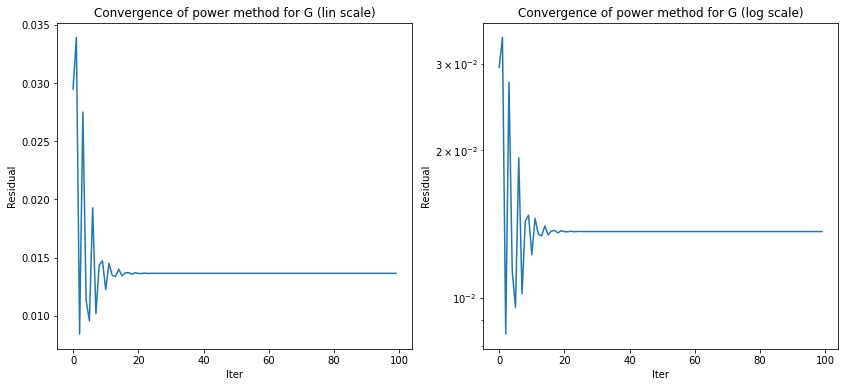

In [616]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(res)
plt.title('Convergence of power method for G (lin scale)')
plt.xlabel('Iter')
plt.ylabel('Residual')

plt.subplot(122)
plt.semilogy(res)
plt.title('Convergence of power method for G (log scale)')
plt.xlabel('Iter')
plt.ylabel('Residual');

The method does not converge because at $k$-th iteration of power method we have (in the basis of eigenvectors, assuming $\lambda_1$ is the largest eigenvalue):

$$A^k x^{(k)} = \sum_{i = 1}^n a_i A^k v_i = \sum_{i = 1}^n a_i \lambda_i^k v_i = a_1 \lambda_1^k (v_1 + \sum_{i = 2}^n \frac{a_i}{a_1} (\frac{\lambda_i}{\lambda_1})^k v_k)$$

The idea of power method is based on assumption that $(\frac{\lambda_i}{\lambda_1})^k \rightarrow 0$ with each iteration, because the fraction is $< 0$. But in our case this does not happen because $\lambda = 1$ has multiplicity 2 and the term $(\frac{1}{1})^k$ is a constant 1 which does not decrease the residual with each iteration.

#### Power method for graph with self-loop

In [617]:
pr = pagerank_matrix(np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 1],
]))
v, lmd, res = power_method(pr, np.random.random(size=(5,)))

In [618]:
v, lmd

(array([0.24224063, 0.48448126, 0.48448126, 0.30720524, 0.61441048]), 1.0)

In [619]:
np.linalg.eig(pr)

(array([-0.5+0.5j, -0.5-0.5j,  1. +0.j , -0.5+0.j ,  1. +0.j ]),
 array([[ 0.35355339+0.35355339j,  0.35355339-0.35355339j,
          0.33333333+0.j        ,  0.        +0.j        ,
         -0.        +0.j        ],
        [ 0.35355339-0.35355339j,  0.35355339+0.35355339j,
          0.66666667+0.j        ,  0.        +0.j        ,
         -0.        +0.j        ],
        [-0.70710678+0.j        , -0.70710678-0.j        ,
          0.66666667+0.j        ,  0.        +0.j        ,
         -0.        +0.j        ],
        [ 0.        +0.j        ,  0.        -0.j        ,
          0.        +0.j        , -0.70710678+0.j        ,
         -0.4472136 +0.j        ],
        [ 0.        +0.j        ,  0.        -0.j        ,
          0.        +0.j        ,  0.70710678+0.j        ,
         -0.89442719+0.j        ]]))

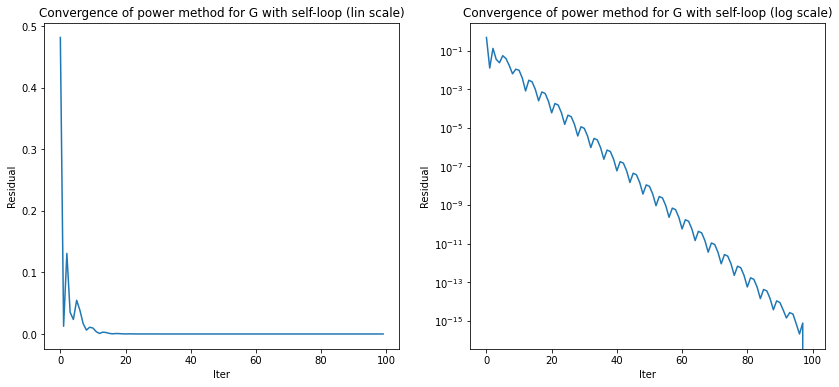

In [620]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(res)
plt.title('Convergence of power method for G with self-loop (lin scale)')
plt.xlabel('Iter')
plt.ylabel('Residual')

plt.subplot(122)
plt.semilogy(res)
plt.title('Convergence of power method for G with self-loop (log scale)')
plt.xlabel('Iter')
plt.ylabel('Residual');

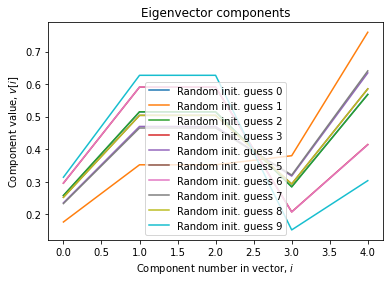

In [621]:
pr = pagerank_matrix(np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 1],
]))

v = np.zeros((5, 10))
lmd = np.zeros(10)
for i in range(10):
    v[:, i], lmd[i], _ = power_method(pr, np.random.random(size=(5,)))
    plt.plot(v[:, i], label=f'Random init. guess {i}')
plt.title('Eigenvector components')
plt.xlabel('Component number in vector, $i$')
plt.ylabel('Component value, $v[i]$')
plt.legend();

The method converges but the eigenvector depends on the initial guess. This happens because the largest eigenvalue still has multiplicity of 2 which still does not allow to compute eigenvectors correctly. Although the eigenvalue and the residual are ok.

#### Power method for dumped graph

In [622]:
pr = pagerank_matrix(np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
]))
d = .95
pr_d = d * pr + (1 - d) / pr.shape[0] * np.ones(pr.shape)
v, lmd, res = power_method(pr_d, np.random.random(size=(5,)))

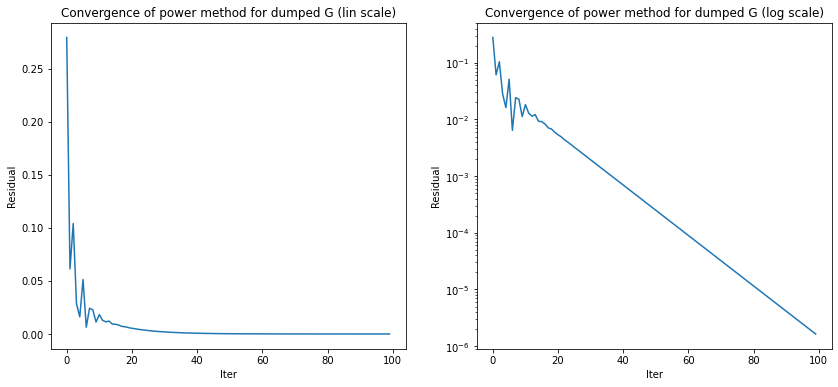

In [623]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(res)
plt.title('Convergence of power method for dumped G (lin scale)')
plt.xlabel('Iter')
plt.ylabel('Residual')

plt.subplot(122)
plt.semilogy(res)
plt.title('Convergence of power method for dumped G (log scale)')
plt.xlabel('Iter')
plt.ylabel('Residual');

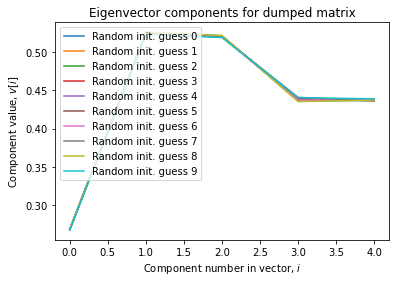

In [624]:
pr = pagerank_matrix(np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
]))
d = .95
pr_d = d * pr + (1 - d) / pr.shape[0] * np.ones(pr.shape)

v = np.zeros((5, 10))
lmd = np.zeros(10)
for i in range(10):
    v[:, i], lmd[i], _ = power_method(pr_d, np.random.random(size=(5,)))
    plt.plot(v[:, i], label=f'Random init. guess {i}')
plt.title('Eigenvector components for dumped matrix')
plt.xlabel('Component number in vector, $i$')
plt.ylabel('Component value, $v[i]$')
plt.legend(loc='upper left');

In [625]:
eigs = np.linalg.eigvals(pr_d)
sorted(eigs, reverse=True)

[(1.0000000000000013+0j),
 (0.95+0j),
 (-0.47499999999999976+0.47500000000000003j),
 (-0.47499999999999976-0.47500000000000003j),
 (-0.9499999999999998+0j)]

The second largest eigenvalue became $\lambda_2 = d \cdot \lambda_1$. Being the second largest coefficient after 1 in $A^k x^{(k)} = a_1 \lambda_1^k (v_1 + \sum_{i = 2}^n \frac{a_i}{a_1} (\frac{\lambda_i}{\lambda_1})^k v_k)$, $d = \frac{\lambda_2}{\lambda_1}$ defines the convergence rate.

#### Fast matvec product

In [584]:
from scipy.sparse import csc_matrix
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    n = A.shape[0]
    return d * A @ x + (1 - d) / n * x.sum()

def Adx_direct(A, d, x):
    n = A.shape[0]
    Ad = d * A + (1 - d) / n * np.ones((n, n))
    return Ad @ x

#### Compare with direct evaluation

In [585]:
from scipy.sparse import random as scsprandom

In [586]:
A = scsprandom(10000, 10000, density=100/10000**2, format='csc')

In [587]:
x = np.random.random(size=(10000))
%timeit pagerank_matvec(A, .85, x)
%timeit Adx_direct(A, .85, x)

119 µs ± 731 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.04 s ± 99.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [630]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [631]:
G, authors

(<1766547x1766547 sparse matrix of type '<class 'numpy.float64'>'
 	with 140388901 stored elements in Compressed Sparse Row format>,
 array(['"lk" G"rler', '(Alex) Chao-Chiang Meng',
        '(TYPE=name) (SCHEME=Vancouver) Kahn Ce', ..., '雅生 森', '順一 山岸',
        '高西 淳夫'], dtype='<U98'))

In [632]:
type(G), type(authors)

(scipy.sparse.csr.csr_matrix, numpy.ndarray)

In [633]:
G.shape, authors.shape

((1766547, 1766547), (1766547,))

In [654]:
n = G.shape[0]
print('density of G:', G.nnz / n**2)

density of G: 4.4986518152305776e-05


In [678]:
authors[np.argsort(G.sum(axis=1), axis=0)][-10:][::-1]

array([['Wei Wang'],
       ['Lei Zhang'],
       ['Yang Liu'],
       ['Wei Zhang'],
       ['Jun Wang'],
       ['Dacheng Tao'],
       ['Philip S. Yu'],
       ['Lei Wang'],
       ['Wei Li'],
       ['Jun Zhang']], dtype='<U98')

In [636]:
A = G > 0

In [637]:
A

<1766547x1766547 sparse matrix of type '<class 'numpy.bool_'>'
	with 140388901 stored elements in Compressed Sparse Row format>

In [665]:
pr = pagerank_matrix(A)
pr

<1766547x1766547 sparse matrix of type '<class 'numpy.float64'>'
	with 140388901 stored elements in Compressed Sparse Row format>

In [651]:
col_sum = pr.sum(axis=1)
nnz_col_sum = col_sum[col_sum > 0]
nnz_col_sum.max(), nnz_col_sum.min()

(1.0000000000000004, 0.9999999999999993)

Sum of all columns is 1 - the matrix is stochastic.

#### PageRank matvec

In [652]:
d = .85
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

In [653]:
L

<1766547x1766547 _CustomLinearOperator with dtype=float64>

In [669]:
v, lmd, res = power_method(L, np.ones((n, 1)), num_iter=20)

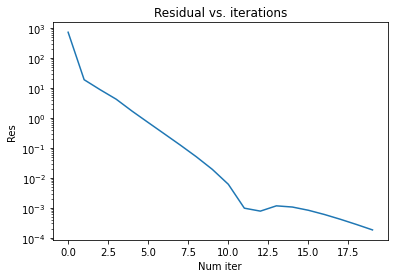

In [670]:
plt.semilogy(res)
plt.title('Residual vs. iterations')
plt.xlabel('Num iter')
plt.ylabel('Res');

In [677]:
authors[np.argsort(v, axis=0)][-10:][::-1]

array([['Wei Wang'],
       ['Yang Liu'],
       ['Lei Zhang'],
       ['Wei Zhang'],
       ['Lei Wang'],
       ['Wei Li'],
       ['Yan Zhang'],
       ['Jun Zhang'],
       ['Wei Liu'],
       ['Jun Wang']], dtype='<U98')

## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

In [12]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [13]:
# Your solution is here

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [14]:
# Your solution is here

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

In [15]:
def qr_algorithm_reileigh(A_init, num_iter):
    # enter your code here
    return Ak, convergence

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

In [16]:
# Your solution is here

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [17]:
def qr_algorithm_wilkinson(A_init, num_iter):
    # enter your code here
    return Ak, convergence

In [18]:
# Your solution is here

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.


In [816]:
# Importing Libraries
import numpy as np
import pandas as pd

# Read the dataset
movies = pd.read_table('movies.dat',  sep='::',  header=None, encoding='latin-1')
users = pd.read_csv('users.dat', sep='::', header=None, encoding='latin-1')
ratings = pd.read_csv('ratings.dat', sep='::', header=None, encoding='latin-1')

C:\Users\kuzne\anaconda3\envs\tf\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [817]:
movies

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [818]:
movies.describe(include=object)

,1,2
count,3883,3883
unique,3883,301
top,Toy Story (1995),Drama
freq,1,843


In [819]:
users.loc[1, 0]

2

In [820]:
users

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [821]:
ratings

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [822]:
# Create the interaction matrix
M = np.zeros((len(users), len(movies)))

for _, row in ratings.iterrows():
    i = users[users[0] == row[0]].index[0]
    j = movies[movies[0] == row[1]].index[0]
    M[i, j] = row[2]
    
# Normalize the matrix

In [823]:
Ms = csc_matrix(M)

In [824]:
Ms.shape, Ms.nnz, Ms.nnz / Ms.shape[0] / Ms.shape[1]

((6040, 3883), 1000209, 0.04264679797998748)

In [825]:
from scipy.sparse.linalg import svds

In [826]:
# Compute Singular Value Decomposition of interaction matrix. You can use built-in functions
S = svds(Ms, k=min(Ms.shape)//100, return_singular_vectors=False)
S = S[::-1]

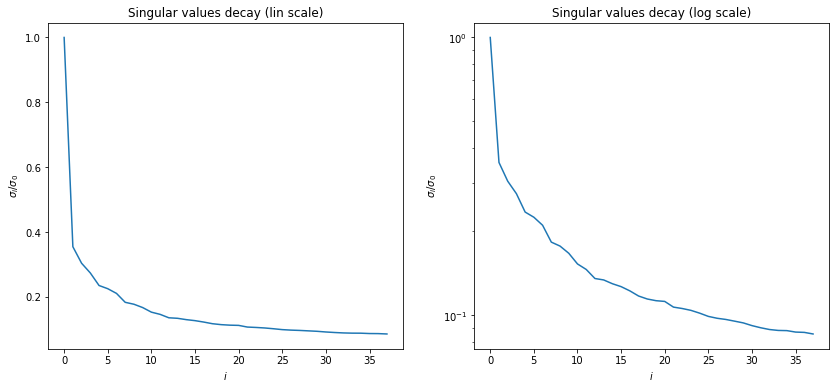

In [827]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(S / S[0])
plt.title('Singular values decay (lin scale)')
plt.xlabel('$i$')
plt.ylabel('$\sigma_i/\sigma_0$');

plt.subplot(122)
plt.semilogy(S / S[0])
plt.title('Singular values decay (log scale)')
plt.xlabel('$i$')
plt.ylabel('$\sigma_i/\sigma_0$');

According to these graphs, after 15th value sing. values do not change very much which means we can leave 15 values to work with.

In [828]:
U, S, Vt = svds(Ms, k=15)

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [829]:
# Your solutuion is here
item_latent_factors = S.reshape((15, 1)) * Vt

In [830]:
item_latent_factors.shape

(15, 3883)

Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [831]:
# Your solutuion is here
def cos(u, v):
    return u.dot(v) / np.linalg.norm(u) / np.linalg.norm(v)

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [832]:
movies

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [834]:
# Your solutuion is here
my_movie = 'Jackie Brown (1997)'
movies.loc[movies[1] == my_movie]

,0,1,2
1680,1729,Jackie Brown (1997),Crime|Drama


In [835]:
ind = movies.loc[movies[1] == my_movie].index[0]
ind

1680

In [836]:
my_vec = item_latent_factors[:, ind]

In [837]:
similarity = np.zeros(item_latent_factors.shape[1])
for j in range(item_latent_factors.shape[1]):
    movie = item_latent_factors[:, j]
    similarity[j] = cos(movie, my_vec)

In [838]:
arg = np.argsort(similarity)[:15][::-1]
arg

array([2161, 1689, 1520,  631, 2526, 1650, 1712,  814,  107, 2889,  785,
       2159,  113, 1710,   50], dtype=int64)

In [839]:
print("You've watched: ", my_movie)
print('If you liked this title, you might also like:')
movies.loc[arg]

You've watched:  Jackie Brown (1997)
If you liked this title, you might also like:


,0,1,2
2161,2230,Always Tell Your Wife (1923),Comedy
1689,1740,Men of Means (1998),Action|Drama
1520,1559,"Next Step, The (1995)",Drama
631,636,Frisk (1995),Drama
2526,2595,Photographer (Fotoamator) (1998),Documentary
1650,1697,"Big Bang Theory, The (1994)",Crime
1712,1768,Mat' i syn (1997),Drama
814,825,Echte Kerle (1996),Comedy|Romance
107,109,Headless Body in Topless Bar (1995),Comedy
2889,2958,Naturally Native (1998),Drama


Enjoy watching the recommended movies!
